In [1]:
"""
Example demonstrating the Robotics Toolbox adapter usage.

This example shows how to use the RTB adapter to:
1. Initialize the environment
2. Load/create robots and objects
3. Perform basic operations like forward kinematics, pose manipulation, etc.
"""

import numpy as np
import spatialmath as sm
import spatialgeometry as sg
from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.geometry.utils import convert_pose
from pandaSim.geometry.utils import create_virtual_panda
import trimesh
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)
import qpsolvers as qp


# auto reload
%load_ext autoreload
%autoreload 2

[I 07/17/25 13:48:24.359 31388] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda = create_virtual_panda(urdf_path=panda_path)

In [54]:
adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": 'google-chrome' # "notebook" for visualizing in jupyter notebook
})
    

panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda = create_virtual_panda(urdf_path=panda_path)
    
env = adapter.env
# Open the gripper fingers (from sample code)
if hasattr(panda, 'grippers') and len(panda.grippers) > 0:
    panda.grippers[0].q = [0.035, 0.035]
    
box = sg.Box(scale=[0.2, 0.07, 0.1], 
             color='blue', 
             pose=sm.SE3(0.7, 0, 0.05))


# end-effector axes
ee_axes = sg.Axes(0.1)
ee_axes.T = panda.fkine(panda.q, end='panda_finger_virtual')

# goal axes
goal_axes = sg.Axes(0.1)


bTe = sm.SE3(-box.scale[0]/2 + 0.02 + 0.2, 0.2, box.scale[2]/2 - 0.02 + 0.5) * sm.SE3.Rx(np.pi/2)
Tep = box.T * bTe
goal_axes.T = Tep




# Add the axes to the environment
env.add(ee_axes)
env.add(goal_axes) 

env.add(panda)
env.add(box)

3

In [70]:
# Direct instantiation
from pandaSim.control import QPController

controller = QPController(adapter=adapter, 
                          gains_translation=1.0, 
                          gains_rotation=0.2, 
                          threshold=0.01, 
                          end_effector_link='panda_finger_virtual', 
                          lambda_q=0.5, 
                          lambda_m=0.0, 
                          lambda_j=1.0,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog')


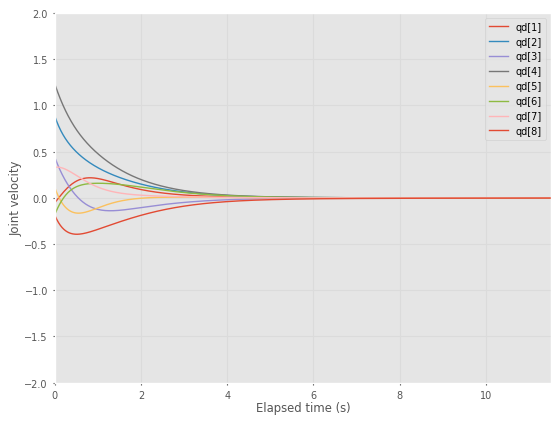

In [71]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

panda.q = panda.qr
arrived = False

qd_history = []
q_history = []
time_history = []

dt = 0.01
elapsed_time = 0.0

fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'qd[{i+1}]', linewidth=1)[0] for i in range(panda.n)]
ax.set_xlim(0, 20) 
ax.set_ylim(-2, 2)   
ax.set_xlabel('Elapsed time (s)')
ax.set_ylabel('Joint velocity')
ax.legend()
plt.ion()
plt.show()

step = 0
while not arrived:
    qd, arrived = controller.compute_joint_velocities(panda, Tep, optimization_type="j")
    adapter.control_joint_velocities(panda, qd)
    ee_axes.T = panda.fkine(panda.q, end='panda_finger_virtual')
    adapter.step_simulation(dt)
    qd_history.append(qd[:panda.n].copy())
    q_history.append(panda.q[:panda.n].copy())
    elapsed_time += dt
    time_history.append(elapsed_time)
    if step % 10 == 0:  # update plot every 0.1 seconds for speed
        clear_output(wait=True)
        for i, line in enumerate(lines):
            line.set_data(time_history, [q[i] for q in qd_history])
        ax.set_xlim(0, max(5, elapsed_time))
        display(fig)
    step += 1
plt.ioff()
plt.show()


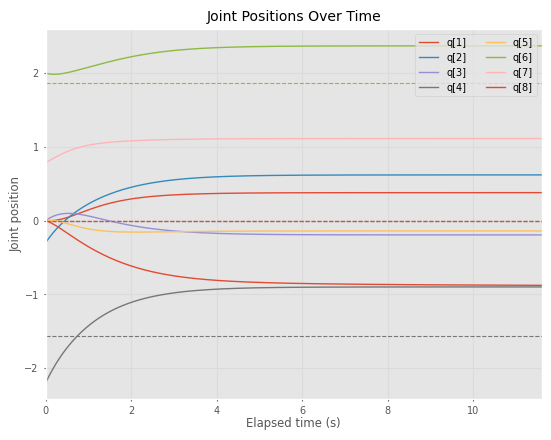

In [72]:
import matplotlib.pyplot as plt

q_history = np.array(q_history)
time_history = np.array(time_history)

# Get joint limits
q_min, q_max = adapter.get_joint_limits(panda)

fig2, ax2 = plt.subplots()
lines = []
for i in range(q_history.shape[1]):
    # Plot joint position
    line, = ax2.plot(time_history, q_history[:, i], label=f'q[{i+1}]', linewidth=1)
    lines.append(line)
    color = line.get_color()
    # Plot middle joint limit as dashed line with same color
    q_mid = (q_min[i] + q_max[i]) / 2
    ax2.hlines(q_mid, time_history[0], time_history[-1], colors=color, linestyles='dashed', linewidth=0.8)

ax2.set_xlim(0, max(time_history))
ax2.set_xlabel('Elapsed time (s)')
ax2.set_ylabel('Joint position')
ax2.set_title('Joint Positions Over Time')
ax2.legend(loc='upper right', ncol=2)
plt.show()




In [18]:
J0 = panda.jacob0(panda.q, end='panda_finger_virtual')
J0_hand = panda.jacob0(panda.q, end='panda_hand')


# print with 0.3 decimal places
print(J0.round(3))
print("--------------------------------")
print(J0_hand.round(3))

[[ 0.    -0.251 -0.017  0.44   0.008  0.227  0.     0.   ]
 [ 0.62  -0.027  0.634  0.033  0.144 -0.012  0.     0.   ]
 [-0.    -0.616 -0.043  0.351 -0.002  0.023  0.     0.   ]
 [ 0.    -0.106  0.645  0.011  0.707 -0.053 -0.29   0.   ]
 [-0.     0.994  0.069 -0.997 -0.049 -0.998 -0.    -1.   ]
 [ 1.     0.     0.761  0.08  -0.705  0.016 -0.957  0.   ]]
--------------------------------
[[-0.    -0.152 -0.011  0.341  0.003  0.128  0.   ]
 [ 0.65  -0.016  0.593  0.035  0.053 -0.006  0.   ]
 [ 0.    -0.646 -0.045  0.381 -0.001  0.053  0.   ]
 [ 0.    -0.106  0.645  0.011  0.707 -0.053 -0.29 ]
 [ 0.     0.994  0.069 -0.997 -0.049 -0.998 -0.   ]
 [ 1.     0.     0.761  0.08  -0.705  0.016 -0.957]]


In [43]:
panda.q = panda.qr
Jm = panda.jacobm(q=panda.q, end='panda_finger_virtual', axes='trans')

print(Jm.round(3))

[[0.   ]
 [0.011]
 [0.   ]
 [0.161]
 [0.   ]
 [0.082]
 [0.   ]
 [0.   ]]
